# Pytorch 개발 Process

1. **데이터 준비**
    - Dataset 준비
    - Dataloader 생성

2. **입력과 출력을 연결하는 Layer(층)으로 이뤄진 네트워크(모델)을 정의**
    - **Sequential 방식**: 순서대로 쌓아올린 네트워크로 이뤄진 모델을 생성하는 방식
        - layer를 순서대로 쌓은 모델을 구현할때 간단히 모델을 정의할 수 있다.
        - layer block을 정의하는데 사용할 수 있다.
    - **Subclass 방식**: 네트워크를 정의하는 클래스를 구현.
        - 다양한 구조의 모델을 정의할 수 있다.
        - inializer에서 필요한 layer들을 생성한다.
        - forward(self, X) 메소드에 forward propagation 계산을 구현한다.
    

3. **train**
    - train 함수, test 함수 정의

4. test set 최종평가

# MNIST 이미지 분류 
- **[MNIST](https://ko.wikipedia.org/wiki/MNIST_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B2%A0%EC%9D%B4%EC%8A%A4) (Modified National Institute of Standards and Technology) database**
- 흑백 손글씨 숫자 0-9까지 10개의 범주로 구분해놓은 데이터셋
- 하나의 이미지는 28 * 28 pixel 의 크기
- 6만개의 Train 이미지와 1만개의 Test 이미지로 구성됨.

## import

In [ ]:
import torch
import torch.nn as nn  # 다양한 layer/모델 들이 정의된 패키지. (Neural Network)
from torch.utils.data import DataLoader # DataLoader 클래스 -> 모델에 데이터들을 제공하는 역할.
from torchvision import datasets, transforms 
# torchvision 패키지(라이브러리): pytorch의 영상상 전용 sub package
## datasets(모듈): Vision(영상)관련 공개개 데이터셋들을 제공하는 모듈, Audio(음성)
## transforms: 영상 데이터 전처리 기능들을 제공하는 모듈

import matplotlib.pyplot as plt

## uv pip install matplotlib

### device 설정

In [ ]:
# 어느 Device에서 연산처리를 할지 지정. (cpu, cuda(GPU))
# device = "cpu"
print(torch.cuda.is_available())  # cuda를 사용할 수있는 환경인지 조회
device = "cuda" if torch.cuda.is_available() else "cpu" # 2.0이전: torch.Device("cuda")
print(device)

In [ ]:
# MAC OS  ("cpu", "mps")
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

### 하이퍼파라미터, 변수 설정

In [70]:
lr = 0.0001 # 학습률. 0 ~ 1 실수. 
batch_size = 256  # 모델이 학습할 때 한 번에 몇 개씩 모델에 제공할지 개수. 
epochs = 20
# step: 모델의 파라미터들을 update하는 단위.
#  - 1 step: batch_size(256)개수의 데이터로 파라미터를 한번 update한 것.
# epoch: train set 전체를 학습하는 단위. 
#  - 1 epoch: 전체 데이터를 한번 다 학습한 것.

In [ ]:
import os
# 학습이 끝난 모델을 저장할 디렉토리.
saved_dir = "models"
os.makedirs(saved_dir, exist_ok=True)
# Dataset을 저장할 디렉토리
dataset_dir = "datasets/mnist"
os.makedirs(dataset_dir, exist_ok=True)

In [ ]:
# 1. Dataset 생성
# 2. DataLoader 생성
# 3. 모델 정의
# 4. 모델 객체
# 5. 손실 함수
# 6. Optimizer 객체 생성
# 7. 학습
# 8. 최종평가

In [99]:
import os
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

lr = 0.00001

batch_size = 256

epochs = 20

saved_dir = "models"
os.makedirs(saved_dir, exist_ok=True)
dataset_dir = "datasets/mnist"
os.makedirs(dataset_dir, exist_ok=True)

In [ ]:
# 1. Dataset 생성
trainset = datasets.MNIST(
    root = dataset_dir,     #Dataset을 읽어올 디렉토리
    download = True,        #root에 dataset이 없을 경우 다운로드 받을지 여부
    transform = transforms.ToTensor()
)


testset = datasets.MNIST(
    root = dataset_dir,
    download = True,
    train = False,          #Train인지 여부. True(default):train set, False:test set
    transform = transforms.ToTensor()
)




# 2. DataLoder 생성
train_loader = DataLoader(
    trainset,                   #적용할 Dataset
    batch_size = batch_size,    #batch_size (256)
    shuffle = True,             #모델에 데이터를 제공하기 전 섞을지 여부
    drop_last = True            #모델에 제공할 데이터의 개수가 batch_size보다 적으면 제공 안함
)

test_loader = DataLoader(
    testset,
    batch_size = batch_size
)




# 3. 모델 정의
class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.lr1 = nn.Linear(784, 128)
        self.lr2 = nn.Linear(128, 64)
        self.lr3 = nn.Linear(64, 32)
        self.lr4 = nn.Linear(32, 10)        #분류할 class 개수 (0 ~ 9)
    
    def forward(self, X):

        X = torch.flatten(X, start_dim=1)
        X = self.lr1(X)
        X = nn.ReLU()(X)

        X = self.lr2(X)
        X = nn.ReLU()(X)

        X = self.lr3(X)
        X = nn.ReLU()(X)

        output = self.lr4(X)
        return output
    



# 4. 모델 객체
model = MNISTModel().to(device)




# 5. 손실 함수
loss_fn = nn.CrossEntropyLoss()



# 6. Optimizer 객체 생성
optimizer = torch.optim.Adam(model.parameters(), lr=lr)



# 7. 학습
train_loss_list = []
valid_loss_list = []
valid_acc_list = []
s = time.time()

for epoch in range(epochs):

    model.train()
    train_loss = 0

    for X_train, y_train in train_loader:

        X_train, y_train = X_train.to(device), y_train.to(device)

        pred = model(X_train)

        loss = loss_fn(pred, y_train)

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

        train_loss = train_loss + loss.item() 

    
    train_loss = train_loss / len(train_loader)
    train_loss_list.append(train_loss)


    model.eval()
    valid_loss = 0
    valid_acc = 0
    with torch.no_grad():

        for X_valid, y_valid in test_loader:
            
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)

            pred_valid = model(X_valid)

            valid_loss = valid_loss + loss_fn(pred_valid, y_valid).item()

            pred_valid_class = pred_valid.argmax(dim=-1)

            valid_acc = valid_acc + torch.sum(y_valid == pred_valid_class).item()
    

In [ ]:

    ###############################################
    # 1 epoch 학습한 결과 검증: Testset
    ###############################################
    model.eval()  # 모델을 evaluation() (추론, 검증) 모드로 변환.
    valid_loss = 0  # 현재 epoch에 대한 검증결과(loss, accuracy) 저장할 변수
    valid_acc = 0
    with torch.no_grad(): # 추론만 함 -> gradient 계산할 필요 없음. -> grad_fn 구할 필요없다.
        for X_valid, y_valid in test_loader:
            # 1. device 로 이동
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)
            # 2. 추론
            pred_valid = model(X_valid)
            # 3-1. 검증 -> loss 계산
            valid_loss = valid_loss + loss_fn(pred_valid, y_valid).item()
            # 3-2. 검증 -> accuracy 계산
            ## pred_valid shape: (256, 10: class별 확률) -> 정답 class 추출
            pred_valid_class = pred_valid.argmax(dim=-1)
            valid_acc = valid_acc + torch.sum(y_valid == pred_valid_class).item()
        
        # 검증결과 누적값의 평균
        valid_loss = valid_loss / len(test_loader)  # loss는 step수 나눔.
        valid_acc = valid_acc / len(testset)        # accuracy는 데이터 개수로 나눔.
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)

        # 검증 결과 출력
        print(f"[{epoch+1:02d}/{epochs}] train_loss: {train_loss}, valid_loss: {valid_loss}, valid_acc: {valid_acc}")

e = time.time()
print('학습에 걸린 시간(초):', e-s)

### MNIST dataset Loading

#### Dataset

In [67]:
trainset = datasets.MNIST(
    root=dataset_dir, # Dataset을 읽어올 디렉토리.
    download=True,    # root 에 dataset이 없을 경우 다운로드 받을지 여부.
    transform=transforms.ToTensor()
)
testset = datasets.MNIST(
    root=dataset_dir,
    download=True,
    train=False,       # Trainset인지 여부. True(default): train set, False: test set
    transform=transforms.ToTensor()
)
######################################################################################
#  transform=함수 -> input data를 전처리하는 함수를 전달.
######################################################################################
# transforms.ToTensor 가 하는 처리
## ndarray, PIL.Image 객체를 torch.Tensor 로 변환.
## (height, width, channel) 순서를 channel first (channel, height, width) 형태로 변환.
## pixcel값들(0~255 정수)을 0 ~ 1 로 정규화. (Feature Scaling - MinMaxScaling)

In [100]:
testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: datasets/mnist
    Split: Test
    StandardTransform
Transform: ToTensor()

In [101]:
# 개별데이터 조회
trainset[0]  # tuple: (input, output)

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
print(trainset[0][1])
trainset[0][0]

In [ ]:
import numpy as np
a = np.array(trainset[0][0])  # PIL.Image -변환-> ndarray
print(a.shape, a.dtype)       # image shape (height, width), uint8(부호없는 int:0~255)
a.min(), a.max()

In [ ]:
################ transforms.ToTensor() 적용 후 확인################
f1 = trainset[0][0]
print(f1.shape)  # (1:channel-grayscale, 28: height, 28:width)
print(f1.dtype, f1.type())
print(f1.min(), f1.max())

60000


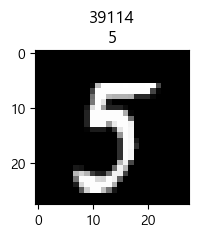

In [66]:
import random
print(len(trainset))
idx = random.randint(0, len(trainset)) #0 ~ 60000 사이 랜덤 정수를 반환.
img, label = trainset[idx]

plt.figure(figsize=(2, 2))
plt.imshow(img.squeeze(), cmap="gray") # (1, 28, 28) -> (28, 28). matplotlib은 이미지를 (h, w, c) 로 전달해야함.
plt.title(f"{idx}\n{label}")
plt.show()    

In [ ]:
type(trainset)

#### DataLoader

In [56]:
# DataLoader: Dataset의 데이터들을 모델에 제공하는 역할. 데이터들을 모델에 어떻게 제공할지 설정해서 생성.
# Dataset: 데이터들을 가지고 있는 역할. 하나씩 조회하는 기능을 제공.
train_loader = DataLoader(
    trainset,              # Dataset
    batch_size=batch_size, # batch size (256)
    shuffle=True,   # 모델에 데이터를 제공하기 전에 섞을지 여부. (default: False) True: 한 epoch 학습 전에 섞는다.
    drop_last=True, # 모델에 제공할 데이터의 개수가 batch_size보다 적으면 제공하지 않는다. (학습에 사용안함)
)

test_loader = DataLoader(testset, batch_size=batch_size)

In [96]:
# 전체 데이터 개수.
len(trainset), len(testset)

(60000, 10000)

In [97]:
# 1 epoch 당 step 수 조회.
len(train_loader), len(test_loader)

(234, 40)

### 모델 정의

In [ ]:
# Class로 구현
## - nn.Module 상속한 클래스를 정의.
## - __init__(): 입력값을 추론(순전파 연산)하는데 필요한 layer객체들을 생성.
## - forward(): __init__() 에서 생성한 layer들을 이용해 연산 로직을 정의

In [57]:
class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__()  # 상위클래스 nn.Module 을 초기화. ##필수
        
        # Linear(input feature 개수, output feature 개수)
        self.lr1 = nn.Linear(784, 128) # (784:(28*28): MNIST 이미지의 pixcel수, 출력: 128) ## 128개에 대한 근거는 없음. 아무 숫자를 넣어도 됨 (필요한 것만 남겨달라는 뜻)
        self.lr2 = nn.Linear(128, 64)  # (128: lr1의 출력개수, 출력: 64)
        self.lr3 = nn.Linear(64, 32)   # (64:  lr2의 출력개수, 출력: 32)
        self.lr4 = nn.Linear(32, 10)   # (32:  lr3의 출력개수, 출력: 10)
        # 마지막 Linear()의 출력 개수(10) - 분류할 class개수(0 ~ 9)

    def forward(self, X):
        """
        X를 입력 받아서 y를 추론하는 계산로직을 정의
        initializer에서 정의한 Linear들을 이용해서 계산.
        Args:
            X(torch.FloatTensor) - 추론할 MNIST 이미지들. shape: (batch_size, 1, 28, 28)
        """
        # (batch_size, 1, 28, 28) 를 (batch_size, 784) feature들을 1차원으로 변환.
        X = torch.flatten(X, start_dim=1) # 다차원 배열을 1차원 배열로 변환. (start_dim=1, Flatten 시킬 시작 axis지정. 0축은 놔두고 1축 부터 flatten시킨다.)
        X = self.lr1(X)  # Linear: 선형함수
        X = nn.ReLU()(X) # Activation(활성) 함수. 비선형함수. ReLU(x): max(x, 0)
        
        X = self.lr2(X)
        X = nn.ReLU()(X)
        
        X = self.lr3(X)
        X = nn.ReLU()(X)
        
        output = self.lr4(X)
        return output

In [ ]:
import torch
import torch.nn


x = torch.randn(256, 1, 28, 28)

model = MNISTModel

p[0]    # 각 클래스별 확률(계산하기 전 값 - logit)

### Train

#### 모델, loss function, optimizer 생성

In [98]:
# 모델객체 생성
model = MNISTModel()
# 확인
print(model)

MNISTModel(
  (lr1): Linear(in_features=784, out_features=128, bias=True)
  (lr2): Linear(in_features=128, out_features=64, bias=True)
  (lr3): Linear(in_features=64, out_features=32, bias=True)
  (lr4): Linear(in_features=32, out_features=10, bias=True)
)


In [ ]:
model = MNISTModel().to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [61]:
# Loss함수 - 학습 할 때 모델이 예측한 값과 정답간의 오차를 계산하는 함수. 이 오차를 줄이는 방향으로 파라미터를 변경한다.
# 다중 분류 문제의 Loss함수: crossentropyloss함수. (이진분류: binary crossentropy, 회귀: mse)
loss_fn = nn.CrossEntropyLoss()  # torch.nn.functional.cross_entropy 함수사용도 가능.

In [63]:
# optimizer 정의: 모델의 파라미터들을 업데이트하고 파라미터들의 gradient값을 초기화 한다.
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#### 학습(훈련-train) 및 검증

In [ ]:
# 학습시 계산에 사용되는 값들은 같은 device(cpu or cuda or mps)에 있어야 한다
## device로 이동할 대상: Model객체, X(input), y(output)

In [64]:
model = MNISTModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
for a in train_loader:


In [71]:
import time
# 학습
## 에폭별 검증결과들을 저장할 리스트
train_loss_list = []
valid_loss_list = []
valid_acc_list = []
s = time.time()

# 학습-중첩 반복문: epoch 반복 -> step(batch_size) 에 대한 반복
for epoch in range(epochs):
    ###############################################
    # 모델 Train - 1 epoch : Trainset
    ###############################################
    model.train()  # 모델을 train 모드로 변환.
    train_loss = 0 # 현재 epoch의 train loss를 저장할 변수.

    # batch 단위로 학습: 1 step - 1개 batch의 데이터로 학습.
    for X_train, y_train  in train_loader: # 한번 반복할 때마다 1개 batch 데이터를 순서대로 제공. (X, y) 를 묶어서 제공한다.
        # 1. X, y를 devcie로 이동 (model과 같은 device로 이동)
        X_train, y_train = X_train.to(device), y_train.to(device)
        # 2. 모델을 이용해 추론
        pred = model(X_train) # Model.forward(X_train) 메소드 호출
        # 3. loss 계산
        loss = loss_fn(pred, y_train)
        # 4. gradient 계산
        loss.backward()
        # 5. 모델의 파라미터들(weight, bias) update
        optimizer.step()
        # 6. gradient 초기화
        optimizer.zero_grad()
        # 학습 결과 저장및 출력을 위해 loss 저장. (1STEP에 대한 LOSS 누적)
        train_loss = train_loss + loss.item() 

    
    train_loss = train_loss / len(train_loader)  # 한 에폭에서 학습한 step별 loss의 평균계산.
    train_loss_list.append(train_loss)
    
    ###############################################
    # 1 epoch 학습한 결과 검증: Testset
    ###############################################
    model.eval()  # 모델을 evaluation() (추론, 검증) 모드로 변환.
    valid_loss = 0  # 현재 epoch에 대한 검증결과(loss, accuracy) 저장할 변수
    valid_acc = 0
    with torch.no_grad(): # 추론만 함 -> gradient 계산할 필요 없음. -> grad_fn 구할 필요없다.
        for X_valid, y_valid in test_loader:
            # 1. device 로 이동
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)
            # 2. 추론
            pred_valid = model(X_valid)
            # 3-1. 검증 -> loss 계산
            valid_loss = valid_loss + loss_fn(pred_valid, y_valid).item()
            # 3-2. 검증 -> accuracy 계산
            ## pred_valid shape: (256, 10: class별 확률) -> 정답 class 추출
            pred_valid_class = pred_valid.argmax(dim=-1)
            valid_acc = valid_acc + torch.sum(y_valid == pred_valid_class).item()
        
        # 검증결과 누적값의 평균
        valid_loss = valid_loss / len(test_loader)  # loss는 step수 나눔.
        valid_acc = valid_acc / len(testset)        # accuracy는 데이터 개수로 나눔.
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)

        # 검증 결과 출력
        print(f"[{epoch+1:02d}/{epochs}] train_loss: {train_loss}, valid_loss: {valid_loss}, valid_acc: {valid_acc}")

e = time.time()
print('학습에 걸린 시간(초):', e-s)

[01/20] train_loss: 0.13894369906913012, valid_loss: 0.14502238284330815, valid_acc: 0.9579
[02/20] train_loss: 0.1344093034346389, valid_loss: 0.14687069496139885, valid_acc: 0.9582
[03/20] train_loss: 0.12987239037950835, valid_loss: 0.140085967653431, valid_acc: 0.9577
[04/20] train_loss: 0.1264754003789435, valid_loss: 0.13651082273572684, valid_acc: 0.9596
[05/20] train_loss: 0.12227828276908806, valid_loss: 0.13413822276052087, valid_acc: 0.96
[06/20] train_loss: 0.11861717965230982, valid_loss: 0.12918084955308587, valid_acc: 0.9607
[07/20] train_loss: 0.11523715145567544, valid_loss: 0.1284787854645401, valid_acc: 0.9614
[08/20] train_loss: 0.11176665760895126, valid_loss: 0.12880516960285604, valid_acc: 0.9603
[09/20] train_loss: 0.10861935378967696, valid_loss: 0.12338301967829465, valid_acc: 0.9636
[10/20] train_loss: 0.10532159245230703, valid_loss: 0.12056862709578127, valid_acc: 0.9634
[11/20] train_loss: 0.10276636412828906, valid_loss: 0.12092580124735833, valid_acc: 0.

In [ ]:
len(test_loader)

#### 학습 로그 시각화

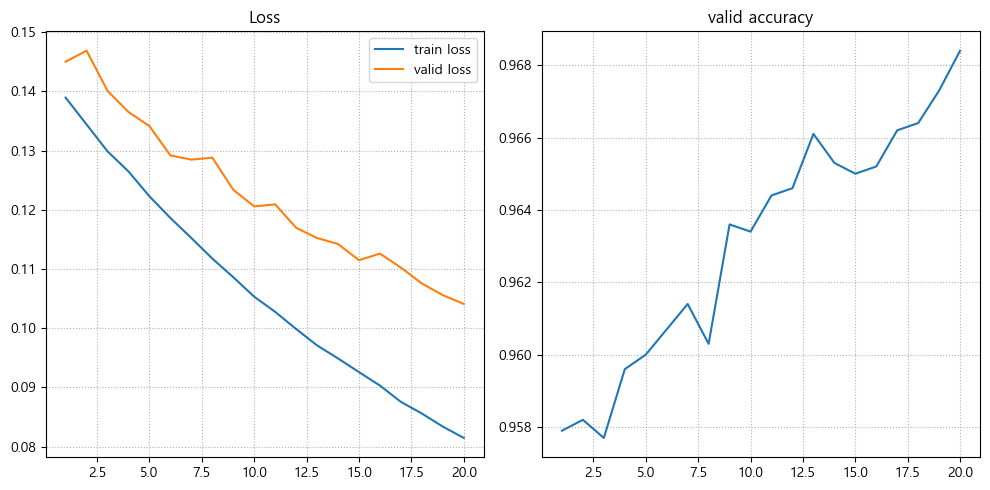

In [72]:
# train loss, valid loss, valid acc 를 epoch 별로 어떻게 변하는지 시각화.
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_loss_list, label="train loss")
plt.plot(range(1, epochs+1), valid_loss_list, label="valid loss")
plt.title("Loss")
plt.legend()
plt.grid(True, linestyle=":")

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), valid_acc_list)
plt.title("valid accuracy")

plt.tight_layout()
plt.grid(True, linestyle=":")
plt.show()


### 학습된 모델 저장 및 불러오기

In [73]:
import os
# saved_dir = "models"
# os.makedirs(saved_dir, exist_ok=True)

save_path = os.path.join(saved_dir, "mnist_model.pt")
save_path

'models\\mnist_model.pt'

In [74]:
# 모델 저장: 파일 확장자 - pt, pth
torch.save(model, save_path)  #  (저장할 모델, 저장할 파일 경로)

In [75]:
# 저장된 모델 load(불러오기)
load_model = torch.load(save_path, weights_only=False)
print(load_model)

MNISTModel(
  (lr1): Linear(in_features=784, out_features=128, bias=True)
  (lr2): Linear(in_features=128, out_features=64, bias=True)
  (lr3): Linear(in_features=64, out_features=32, bias=True)
  (lr4): Linear(in_features=32, out_features=10, bias=True)
)


## 모델 성능 최종 평가

In [77]:
load_model = load_model.to(device)
load_model.eval() # 평가모드

test_loss = test_acc = 0
with torch.no_grad():
    for X_test, y_test in test_loader:
        # device 이동
        X_test, y_test = X_test.to(device), y_test.to(device)
        # 추론
        pred_test = load_model(X_test)
        # 검증 - loss
        loss_test = loss_fn(pred_test, y_test)
        test_loss += loss_test.item()
        # 검증 - accuracy
        ## class
        pred_test_class = pred_test.argmax(dim=-1)
        test_acc += torch.sum(pred_test_class == y_test).item()

    test_loss = test_loss / len(test_loader)
    test_acc = test_acc / len(testset)

In [78]:
print(test_loss, test_acc)

0.10411171729210764 0.9684


In [79]:
p = load_model(X_test)
p.shape

torch.Size([16, 10])

In [80]:
p_class = p.argmax(dim=-1)

In [81]:
torch.sum(y_test == p_class).item() # 맞은 것의 개수.

16

## 새로운 데이터 추론

In [82]:
from PIL import Image

# python 이미지 다루기: OpenCV
#                       PIL (Pillow)

def load_data(device="cpu", *path):
    """
    받은 경로의 이미지들을 읽어서 Tensor로 변환해 반환한다.

    1. 전달받은 경로의 이미지 파일들을 읽는다.
    2. 28 x 28 로 resize
    3. torch.Tensor로 변환 + 전처리
    4. devcie로 이동시킨 뒤 반환한다다.
    """
    input_tensors = []
    for p in path:
        img = Image.open(p)
        img = img.convert('L')     # color -> grayscale로 변환.
        img = img.resize((28, 28)) # 모델이 학습한 데이터 size(28, 28)로 변환.  #LR1 ->784 이니까 (28, 28) 해야함
        img = transforms.ToTensor()(img)    # Image -> Torch.Tensor으로 변환. channel first (1, 28, 28)로 변환, 정규화(0~255->0~1, MinMaxscaler)
        input_tensors.append(img)
        
    return torch.stack(input_tensors).to(device)

In [85]:
def predict(model, inputs, device="cpu"):
    """
    받은 model에 inputs를 추론하여 그 결과 class들을 반환한다.
    """
    with torch.no_grad():
        model = model.to(device)
        model.eval()
        pred = model(inputs)
        pred_class = pred.argmax(dim=-1)
        return pred_class

In [ ]:
# With torch.no_grad 대신 torch.no_grad decorator를 사용해서 grad_fn을 생략할 수 있다
@torch.no_grad
def predict(model, inputs, device="cpu"):
    """
    받은 model에 inputs를 추론하여 그 결과 class들을 반환한다.
    """
    model = model.to(device)
    model.eval()
    pred = model(inputs)
    pred_class = pred.argmax(dim=-1)
    return pred_class

In [88]:
r = load_data("cpu", "test_img/eight.png", "test_img/four2.png")

r.shape

predict(load_model, r)

tensor([6, 4])

In [89]:
# glob을 이용해 테스트 이미지들의 경로 조회.
from glob import glob
file_list = glob("test_img/*.png")
file_list

['test_img\\eight.png',
 'test_img\\eight2.png',
 'test_img\\five.png',
 'test_img\\four.png',
 'test_img\\four2.png',
 'test_img\\one.png',
 'test_img\\seven.png',
 'test_img\\seven2.png',
 'test_img\\seven3.png',
 'test_img\\three.png',
 'test_img\\three2.png',
 'test_img\\two.png',
 'test_img\\two2.png']

In [90]:
r = load_data(device, *file_list)
result_pred = predict(load_model, r)
result_pred

tensor([6, 5, 5, 9, 4, 6, 7, 2, 3, 3, 3, 2, 2])

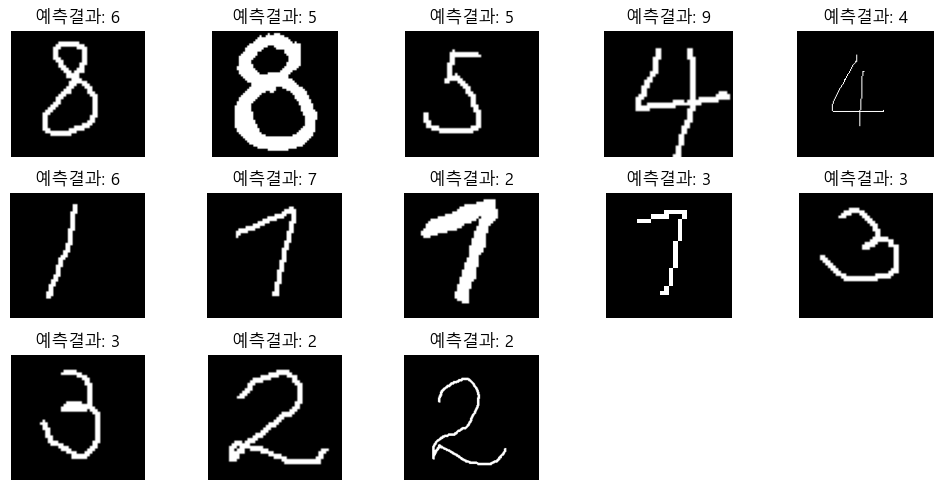

In [91]:
# 확인


plt.figure(figsize=(10, 5))
for idx, (path, label) in enumerate(zip(file_list, result_pred)):
    # print(idx, path, label, sep=" , ")
    img = Image.open(path).convert('L')
    plt.subplot(3, 5, idx+1)  #3, 4
    plt.imshow(img, cmap="gray")
    plt.title(f"예측결과: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()